In [22]:
import pandas as pd
import os
from caveclient import CAVEclient
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [23]:
# initialize CAVE client to access dataset 

client = CAVEclient()

if not os.path.isfile(os.path.expanduser("~/.cloudvolume/secrets/cave-secret.json")):
    client.auth.get_new_token(open=True)

datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)

In [24]:
# segids of club neurons grouped by cosine similarity, refer to Figure4_tonotopy python notebook 

dorsal_club_t1l = [648518346488912397,
648518346503137403,
648518346499541854,
648518346509233018,
648518346492002415,
648518346494263154,
648518346511235381,
648518346500706739,
648518346531374106,
648518346481703327]

medial_club_t1l = [648518346517527332,
648518346531363354,
648518346499840723,
648518346488978410,
648518346484528131,
648518346486545841,
648518346490136273,
648518346488054046,
648518346524142085]

ventral_club_t1l = [648518346495414351,
648518346481068634,
648518346522179866,
648518346495765904,
648518346511819888,
648518346514007065,
648518346514428359,
648518346494038560,
648518346498554608,
648518346497858151,
648518346482976742,
648518346477963245,
648518346524144133,
648518346472537865,
648518346487705300,
648518346499385438,
648518346503767201,
648518346499893315]

# T2R 
dorsal_club_t2r = [648518346483806357,
648518346478167277,
648518346492356223,
648518346475974370,
648518346488045079,
648518346499960531,
648518346518565462]

medial_club_t2r = [648518346493225392,
648518346474234477,
648518346502655814]

ventral_club_t2r = [648518346495993163,
648518346492913070,
648518346477811470,
648518346494998706]

In [25]:
# import and organize data for each club group (T1L/T2R, dorsal/medial/ventral) from the feco_axons_v0 annotation table 

# import entire feco_axons_vo table 
feco_df_all = client.materialize.query_table('feco_axons_v0') 

# separate out T1L and T2R club neurons 
t1l_club_df = feco_df_all[(feco_df_all.cell_type.str.contains('club')) & (feco_df_all.classification_system == 'T1L')]
t2r_club_df = feco_df_all[(feco_df_all.cell_type.str.contains('club')) & (feco_df_all.classification_system == 'T2R')]

# create a new column in the dataframes to identify whether the club neuron is dorsal/medial/ventral 
t1l_cos_group = [] 
t2r_cos_group = []

for id in t1l_club_df.pt_root_id: 
    
    if id in dorsal_club_t1l: 
        t1l_cos_group.append('dorsal')
        
    elif id in medial_club_t1l: 
        t1l_cos_group.append('medial')
        
    elif id in ventral_club_t1l: 
        t1l_cos_group.append('ventral')
    
    else: 
        t1l_cos_group.append('other')
        
t1l_club_df['cos_group'] = t1l_cos_group 
        

for id in t2r_club_df.pt_root_id: 
    
    if id in dorsal_club_t2r: 
        t2r_cos_group.append('dorsal')
        
    elif id in medial_club_t2r: 
        t2r_cos_group.append('medial')
        
    elif id in ventral_club_t2r: 
        t2r_cos_group.append('ventral')
    
    else: 
        t2r_cos_group.append('other')
        
t2r_club_df['cos_group'] = t2r_cos_group 



/var/folders/ds/x7td6nf906g264l63pfg2zz40000gn/T/ipykernel_88509/825192305.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1l_club_df['cos_group'] = t1l_cos_group
/var/folders/ds/x7td6nf906g264l63pfg2zz40000gn/T/ipykernel_88509/825192305.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t2r_club_df['cos_group'] = t2r_cos_group


In [60]:
# functions to generate postsynaptic synapse positions of each club cosine group 

def get_synapses(threshold, inputs):

    upstream = False
    syn_thresh = threshold 
    if upstream == True:
        syn_df = client.materialize.synapse_query(post_ids = inputs)
    else:
        syn_df = client.materialize.synapse_query(pre_ids = inputs)

    synapse_df = filt_syn_df(syn_df, syn_thresh)

    x_synapses = [] 
    y_synapses = [] 
    z_synapses = [] 
    neuron_idx = [] 

    counter = 0

    for idx in inputs:      
        if upstream == True:
            syn_df = client.materialize.synapse_query(post_ids = idx) # create synapse df for each segid 
        else:
            syn_df = client.materialize.synapse_query(pre_ids = idx)

        synapse_df = filt_syn_df(syn_df, syn_thresh)
        synapse_df = synapse_df.reset_index()
        neuron_idx.extend(np.ones(len(synapse_df)) * counter) # create neuron index to reference later 
        counter = counter + 1 

        for synapse in range(0, len(synapse_df)): 
            if upstream == True: 
                x_synapses.append(synapse_df.pre_pt_position[synapse][0]) # fill x,y,z synapse positions 
                y_synapses.append(synapse_df.pre_pt_position[synapse][1]) 
                z_synapses.append(synapse_df.pre_pt_position[synapse][2]) 

            else: 
                x_synapses.append(synapse_df.post_pt_position[synapse][0]) 
                y_synapses.append(synapse_df.post_pt_position[synapse][1]) 
                z_synapses.append(synapse_df.post_pt_position[synapse][2]) 


    # Create dataframe for plotting 
    synapse_hist = {'x_synapses': x_synapses,
                    'y_synapses': y_synapses, 
                    'z_synapses': z_synapses, 
                    'neuron' : neuron_idx}

    # Create DataFrame
    synapse_hist_df = pd.DataFrame(synapse_hist)
    
    return synapse_hist_df

# filter function to constrain to partners that make threshold number of synapses 

def filt_syn_df(syn_df, syn_thresh):
    
    indices_to_include = []

    # Find unique presynaptic neurons
    unique_pre_ids = syn_df.pre_pt_root_id.unique().tolist()

    # Loop through presynaptic neurons
    for i in unique_pre_ids:       
        pre_df = syn_df[syn_df.pre_pt_root_id == i]
        # Find unique postsynaptic neurons targeted by i-th presynaptic neuron
        unique_post_ids = pre_df.post_pt_root_id.unique().tolist() 
        # Loop through postsynaptic neurons
        for j in unique_post_ids:    
            # Is number of synapses onto j-th postsynaptic neuron larger than or equal to syn_thresh? 
            if sum(pre_df.post_pt_root_id == j) >= syn_thresh: 
                # Get indices (rows)
                indices = pre_df.index.values[pre_df.post_pt_root_id == j]       
                # Loop through indices 
                for k in indices:
                    # Append each index separately to avoid lists within list
                    indices_to_include.append(k)

    # Sort indices in ascending order
    indices_to_include.sort()
    
    # Create new syn_df with only connections above syn_thresh
    syn_df_filt = syn_df.loc[indices_to_include]
    
    return syn_df_filt


In [61]:
# get postsynaptic synapse positions for each club group 

dorsal_t1l_hist_df = get_synapses(3, t1l_club_df[t1l_club_df.cos_group == 'dorsal'].pt_root_id.tolist())
medial_t1l_hist_df = get_synapses(3, t1l_club_df[t1l_club_df.cos_group == 'medial'].pt_root_id.tolist())
ventral_t1l_hist_df = get_synapses(3, t1l_club_df[t1l_club_df.cos_group == 'ventral'].pt_root_id.tolist())

dorsal_t2r_hist_df = get_synapses(3, t2r_club_df[t2r_club_df.cos_group == 'dorsal'].pt_root_id.tolist())
medial_t2r_hist_df = get_synapses(3, t2r_club_df[t2r_club_df.cos_group == 'medial'].pt_root_id.tolist())
ventral_t2r_hist_df = get_synapses(3, t2r_club_df[t2r_club_df.cos_group == 'ventral'].pt_root_id.tolist())

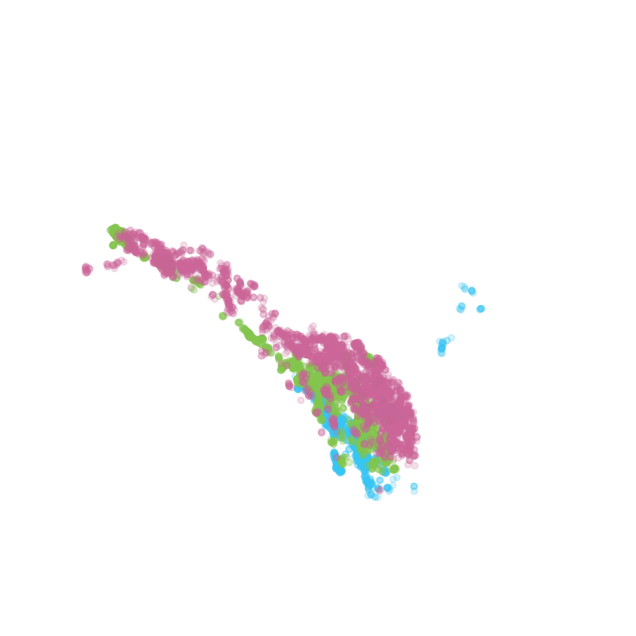

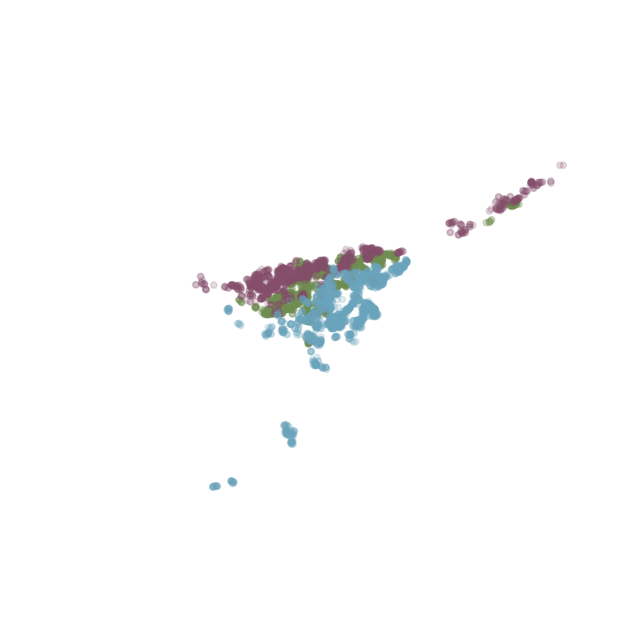

In [100]:
# Plot synapses 

# T1L 
fig = plt.figure(figsize = (8,8)) 
ax = plt.axes(projection ="3d")
ax.set_axis_off()

ax.scatter3D(dorsal_t1l_hist_df.x_synapses, dorsal_t1l_hist_df.y_synapses, dorsal_t1l_hist_df.z_synapses, color='#36c6f4',alpha = 0.2)
ax.scatter3D(medial_t1l_hist_df.x_synapses, medial_t1l_hist_df.y_synapses, medial_t1l_hist_df.z_synapses, color = '#83c54d',alpha = 0.3)
ax.scatter3D(ventral_t1l_hist_df.x_synapses, ventral_t1l_hist_df.y_synapses, ventral_t1l_hist_df.z_synapses, color = '#CC6699',alpha = 0.2)


#T2R 
fig = plt.figure(figsize = (8,8)) 
ax = plt.axes(projection ="3d")
ax.set_axis_off()

# Creating plot
ax.scatter3D(dorsal_t2r_hist_df.x_synapses, dorsal_t2r_hist_df.y_synapses, dorsal_t2r_hist_df.z_synapses, color='#6AA4BC',alpha = 0.2)
ax.scatter3D(medial_t2r_hist_df.x_synapses, medial_t2r_hist_df.y_synapses, medial_t2r_hist_df.z_synapses, color = '#708D51',alpha = 0.3)
ax.scatter3D(ventral_t2r_hist_df.x_synapses, ventral_t2r_hist_df.y_synapses, ventral_t2r_hist_df.z_synapses, color = '#854E6B',alpha = 0.2)
